We create ruleset for peptides length 9 

Note, with unpickle (Jype JUnpickler especially), you may encounter error: 

<p style="color: blue">java.lang.NoSuchMethodError: java.nio.ByteBuffer.position(I)Ljava/nio/ByteBuffer;</p>

For this error, I just uninstalled and then reinstalled jpype (conda install -c conda-forge jpype1) and it resolved

We use 'C2' Bruha modified coleman's C2 statistic:
$\frac{\frac{(P+N)*p}{(p+n)}-P}{N}*(\frac{1+\frac{p}{P}}{2})$

Where,
1. TP = p
2. FP = n
3. TN = N-n
4. FN = P-p
5. P + N = total samples

In [16]:
# import libraries
import pandas as pd
import numpy as np
import time
import itertools
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from rulekit.classification import RuleClassifier, ExpertRuleClassifier
from rulekit.params import Measures
from rulekit._helpers import *
from jpype.pickle import JPickler, JUnpickler

from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, roc_curve, auc
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV

from sklearn.model_selection import train_test_split
from src.utils import *
from src.utils_rules import *
from src.MHCRule import *

In [2]:
# seed everyhting
set_seed(42)
_ = RuleClassifier()

Jun 24, 2024 7:47:19 PM com.rapidminer.tools.I18N <clinit>
INFO: Set locale to en.


In [3]:
# read data file
BA_df = pd.read_csv('./Data/Data_HLA.csv', index_col=0)
BA_df = BA_df[BA_df['peptide_length']==9].reset_index(drop=True)

BA_df

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_kind,measurement_source,original_allele,fold_0,fold_1,fold_2,fold_3,y,peptide_length
0,HLA-A*01:01,AADFPGIAR,20000.0,>,quantitative,affinity,Buus - purified MHC/direct/fluorescence,HLA-A*01:01,True,True,True,True,0,9
1,HLA-A*01:01,AADKAAAAY,50.0,=,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,HLA-A*01:01,False,True,True,True,1,9
2,HLA-A*01:01,AADSFATSY,76.3,=,quantitative,affinity,Buus - purified MHC/direct/fluorescence,HLA-A*01:01,True,True,True,True,1,9
3,HLA-A*01:01,AAFLDDNAF,20000.0,>,quantitative,affinity,Buus - purified MHC/direct/fluorescence,HLA-A*01:01,True,True,True,True,0,9
4,HLA-A*01:01,AAGLPAIFV,5000.0,>,qualitative,affinity,Buus - purified MHC/direct/fluorescence,HLA-A*01:01,True,True,True,False,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127773,HLA-C*15:02,YVYFYDLSY,1775.0,=,quantitative,affinity,Ph.D. - purified MHC/direct/fluorescence,HLA-C*15:02,True,True,True,True,0,9
127774,HLA-C*15:02,YWMGGTTYF,20000.0,>,quantitative,affinity,Ph.D. - purified MHC/direct/fluorescence,HLA-C*15:02,True,True,True,True,0,9
127775,HLA-C*15:02,YYFSYPLFV,771.0,=,quantitative,affinity,Ph.D. - purified MHC/direct/fluorescence,HLA-C*15:02,True,True,True,True,0,9
127776,HLA-C*15:02,YYGRWVHEF,20000.0,>,quantitative,affinity,Ph.D. - purified MHC/direct/fluorescence,HLA-C*15:02,True,True,True,True,0,9


In [4]:
# Read count df
count_df = pd.read_csv('./Data/HLA_peptide_count.csv',index_col=0)

# HLA list
# Make sure we have atleast 10 peptides with atleast 5 +ve and -ve peptides
allele_ls = count_df[(count_df['positives']>5)&(count_df['negatives']>5)&(count_df['total']>10)]['allele'].to_list()

## Peptide encoded with hydrophobic scale 'KOEH090101' from AA ontology (MHCRule Hydro)

Here we create rules per HLA for peptides of length 9 but do not take HLA sequence

In [5]:
# train classifier
hydro = MHCRuleHydro(scale='KOEH090101',
                       max_growing=0,
                       minsupp_new=13,
                       pruning_measure='C2', 
                       voting_measure='C2',
                       induction_measure='C2', 
                       complementary_conditions=False)

result_df, hydro = fit_loop(model=hydro, 
                              allele_ls=allele_ls, 
                              df=BA_df, 
                              test_size=0.3, 
                              retrain=False)
result_df

 46%|███████████████████████████████████████████████████████████████████████████▌                                                                                          | 46/101 [02:27<00:20,  2.74it/s]No positive samples in y_true, true positive value should be meaningless
No positive class found in y_true, recall is set to one for all thresholds.
 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 70/101 [02:31<00:03,  9.92it/s]No positive samples in y_true, true positive value should be meaningless
No positive class found in y_true, recall is set to one for all thresholds.
 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 76/101 [02:31<00:02, 10.50it/s]No positive samples in y_true, true positive value should be meaningless
No positive class

,allele,peptide_count,train_time,train_accuracy,train_f1,train_auroc,train_auprc,valid_accuracy,valid_f1,valid_auroc,valid_auprc,test_accuracy,test_f1,test_auroc,test_auprc,rule_count
0,HLA-A*02:01,11610,32.151516,0.814569,0.765885,0.892996,0.820512,0.808840,0.749436,0.877404,0.792214,0.805284,0.749815,0.881404,0.792620,347
0,HLA-A*03:01,5615,7.186437,0.856743,0.732542,0.916076,0.790446,0.856465,0.745263,0.906192,0.779533,0.845606,0.693396,0.897636,0.697881,113
0,HLA-A*11:01,4697,4.222599,0.853057,0.773558,0.925602,0.839297,0.836879,0.748359,0.896825,0.810939,0.839716,0.739030,0.890608,0.772949,74
0,HLA-A*02:03,4449,9.344092,0.833654,0.770186,0.906655,0.834337,0.823353,0.760163,0.887244,0.821937,0.818591,0.752556,0.879105,0.780352,133
0,HLA-A*31:01,3962,3.893517,0.841327,0.735259,0.926552,0.817823,0.843697,0.725664,0.897363,0.689233,0.833333,0.719547,0.912838,0.739275,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,HLA-A*03:19,30,0.022448,0.952381,0.947368,0.950000,0.973810,0.600000,0.500000,0.583333,0.600000,1.000000,1.000000,1.000000,1.000000,5
0,HLA-B*55:02,16,0.036952,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.666667,NaN,1.000000,6
0,HLA-C*12:02,17,0.016731,1.000000,1.000000,1.000000,1.000000,0.666667,0.800000,0.500000,0.833333,1.000000,1.000000,NaN,1.000000,3
0,HLA-A*03:02,18,0.020792,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,0.333333,0.500000,0.750000,0.750000,4


In [6]:
# Save results data and model
result_df.reset_index(drop=True).to_csv('./results/MHCRule/training_results/MHCRuleHydro.csv')

with open('./model/MHCRuleHydro.pkl','wb') as f:
    pickle.dump(hydro, f)
    
f.close()

In [7]:
result_df = pd.read_csv('./results/MHCRule/training_results/MHCRuleHydro.csv',index_col=0)
result_df.median(), result_df.std(), result_df.max()

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


(peptide_count     576.000000
 train_time          0.068664
 train_accuracy      0.934116
 train_f1            0.840000
 train_auroc         0.939453
 train_auprc         0.907301
 valid_accuracy      0.837079
 valid_f1            0.707317
 valid_auroc         0.830633
 valid_auprc         0.752265
 test_accuracy       0.833333
 test_f1             0.666667
 test_auroc          0.822801
 test_auprc          0.738889
 rule_count         13.000000
 dtype: float64,
 peptide_count     1723.998881
 train_time           3.452730
 train_accuracy       0.054096
 train_f1             0.103373
 train_auroc          0.033069
 train_auprc          0.076869
 valid_accuracy       0.128102
 valid_f1             0.246546
 valid_auroc          0.165066
 valid_auprc          0.212817
 test_accuracy        0.160475
 test_f1              0.223544
 test_auroc           0.161692
 test_auprc           0.200729
 rule_count          48.986135
 dtype: float64,
 allele            HLA-C*15:02
 peptide_count      

In [12]:
# Get row data for max rule count 
result_df[result_df['rule_count']==347.0]

,allele,peptide_count,train_time,train_accuracy,train_f1,train_auroc,train_auprc,valid_accuracy,valid_f1,valid_auroc,valid_auprc,test_accuracy,test_f1,test_auroc,test_auprc,rule_count
0,HLA-A*02:01,11610,32.151516,0.814569,0.765885,0.892996,0.820512,0.80884,0.749436,0.877404,0.792214,0.805284,0.749815,0.881404,0.79262,347


# MHC-BENCH v2

In [9]:
with open('./model/MHCRuleHydro.pkl','rb') as f:
    hydro = pickle.load(f)
    
f.close()

In [10]:
mhcbench_df = pd.read_csv('./Data/MHC-Bench_v2.csv',index_col=0)
mhcbench_df = mhcbench_df[mhcbench_df['mhc'].isin(allele_ls)]

# ensure there are no repeated peptides in training and benchmark
mhcbench_df_ls = []

for hla in mhcbench_df['mhc'].unique(): 
    BA_df_tmp = BA_df[BA_df['allele']==hla]
    mhcbench_df_tmp = mhcbench_df[mhcbench_df['mhc']==hla]
    
    mhcbench_df_tmp = mhcbench_df_tmp[~mhcbench_df_tmp['peptide'].isin(BA_df_tmp['peptide'].to_list())] 
    mhcbench_df_ls = mhcbench_df_ls + [mhcbench_df_tmp]
    
mhcbench_df = pd.concat(mhcbench_df_ls,axis=0).reset_index(drop=True)

mhcbench_df = mhcbench_df.rename(columns={'mhc':'allele', 
                                          'binding':'y'})
mhcbench_df

,peptide,allele,y
0,QIYPGIKVK,HLA-A*03:01,1
1,SFTFKEGFK,HLA-A*03:01,1
2,SLFMILCTR,HLA-A*03:01,1
3,TFFKFLADK,HLA-A*03:01,1
4,TLLRKHTLK,HLA-A*03:01,1
...,...,...,...
1395072,WRKLLKGIP,HLA-B*27:06,0
1395073,DANSYENVL,HLA-B*27:06,0
1395074,PAAMKAAAA,HLA-B*27:06,0
1395075,GKLRPACPG,HLA-B*27:06,0


In [13]:
# evaluate on MHCBenchV2

mhcbench_v2_result_df = eval_loop(model=hydro, 
                                  allele_ls=mhcbench_df['allele'].unique(), 
                                  df=mhcbench_df)
mhcbench_v2_result_df.to_csv('./results/MHCRule/mhcbench_v2_results/MHCRuleHydro_mhcbenchv2.csv')
mhcbench_v2_result_df

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [07:33<00:00,  7.09s/it]


,allele,peptide_count,accuracy,f1,auroc,auprc,rule_count
0,HLA-A*03:01,4141,0.948563,0.747331,0.965721,0.758577,113
0,HLA-A*26:01,27286,0.988859,0.254902,0.949255,0.236863,102
0,HLA-A*32:01,47200,0.950763,0.011905,0.839723,0.122096,36
0,HLA-B*07:02,11332,0.952700,0.531469,0.966055,0.606205,87
0,HLA-B*27:05,4958,0.962687,0.291188,0.984865,0.307036,38
...,...,...,...,...,...,...,...
0,HLA-B*27:04,342,0.830409,0.093750,0.500626,0.099501,6
0,HLA-A*26:02,42,0.928571,0.400000,0.956250,0.537500,17
0,HLA-A*69:01,194,0.907216,0.666667,0.917728,0.754336,64
0,HLA-B*39:06,380,0.686842,0.690909,0.830250,0.797667,7


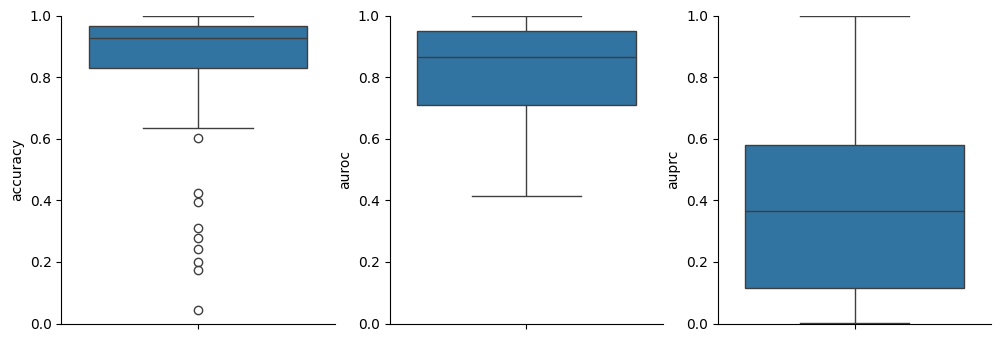

In [14]:
# Metrics

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

b = sns.boxplot(data=mhcbench_v2_result_df, y='accuracy', ax=axs[0])
b.set(ylim=(0,1))

b = sns.boxplot(data=mhcbench_v2_result_df, y='auroc', ax=axs[1])
b.set(ylim=(0,1))

b = sns.boxplot(data=mhcbench_v2_result_df, y='auprc', ax=axs[2])
b.set(ylim=(0,1))

sns.despine(top=True,right=True)


In [15]:
mhcbench_v2_result_df.median()

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


peptide_count    18961.000000
accuracy             0.927288
f1                   0.072655
auroc                0.864579
auprc                0.364158
rule_count          27.000000
dtype: float64